In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from rosbags.highlevel import AnyReader

import numpy as np
import seaborn as sns

import os

## Functions for reading ROS2 bags

In [31]:

def get_pose_data(bag_path, topic_name):
    poses_data = {
        'timestamp': [],
        'time_sec': [],
        'position_x': [],
        'position_y': [],
        'position_z': [],
        'orientation_x': [],
        'orientation_y': [],
        'orientation_z': [],
        'orientation_w': []
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Extract pose data
            poses_data['timestamp'].append(timestamp)
            poses_data['time_sec'].append(timestamp / 1e9)

            poses_data['position_x'].append(msg.position.x)
            poses_data['position_y'].append(msg.position.y)
            poses_data['position_z'].append(msg.position.z)

            poses_data['orientation_x'].append(msg.orientation.x)
            poses_data['orientation_y'].append(msg.orientation.y)
            poses_data['orientation_z'].append(msg.orientation.z)
            poses_data['orientation_w'].append(msg.orientation.w)

    poses_data = pd.DataFrame(poses_data)
    
    # clean up time_sec
    # poses_data['time_sec'] = poses_data['time_sec'] - poses_data['time_sec'].min()
    return poses_data

def get_cmd_vel_data(bag_path, topic_name):
    cmd_vel_data = {
        'timestamp': [],
        'time_sec': [],
        'linear_x': [],
        'angular_z': []
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Extract pose data
            cmd_vel_data['timestamp'].append(timestamp)
            cmd_vel_data['time_sec'].append(timestamp / 1e9)
            cmd_vel_data['linear_x'].append(msg.linear.x)
            cmd_vel_data['angular_z'].append(msg.angular.z)

    cmd_vel_data = pd.DataFrame(cmd_vel_data)

    # clean up time_sec
    # cmd_vel_data['time_sec'] = cmd_vel_data['time_sec'] - cmd_vel_data['time_sec'].min()

    return cmd_vel_data

def get_force_data(bag_path, topic_name):
    force_data = {
        'timestamp': [],
        'time_sec': [],
        'data': []
    }
    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)
            force_data['timestamp'].append(timestamp)
            force_data['time_sec'].append(timestamp / 1e9)
            force_data['data'].append(msg.data)

    force_data = pd.DataFrame(force_data)

    # clean up time_sec
    # force_data['time_sec'] = force_data['time_sec'] - force_data['time_sec'].min()

    return force_data

def get_payload_pose(bag_path, topic_name):
    payload_poses = {
        'timestamp': [],
        'time_sec': [],
        'position_x': [],
        'position_y': [],
        'position_z': [],
        'orientation_x': [],
        'orientation_y': [],
        'orientation_z': [],
        'orientation_w': [],
    }

    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]

        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)

            for t in msg.transforms:
                if t.child_frame_id == 'payload':        
                    # print(t)
                    payload_poses['timestamp'].append(timestamp)
                    payload_poses['time_sec'].append(timestamp / 1e9)

                    payload_poses['position_x'].append(t.transform.translation.x)
                    payload_poses['position_y'].append(t.transform.translation.y)
                    payload_poses['position_z'].append(t.transform.translation.z)

                    payload_poses['orientation_x'].append(t.transform.rotation.x)
                    payload_poses['orientation_y'].append(t.transform.rotation.y)
                    payload_poses['orientation_z'].append(t.transform.rotation.z)
                    payload_poses['orientation_w'].append(t.transform.rotation.w)

    payload_poses = pd.DataFrame(payload_poses)

    return payload_poses


## Functions for plotting

In [32]:
def plot_trajectory(data1, data2, haxis, vaxis, robot_name):
    plt.plot(
        data1,
        data2,
        '-r'
    )
    plt.grid(True)
    plt.xlabel(haxis)
    plt.ylabel(vaxis)
    plt.title(f'Trajectory over time for {robot_name}')
    plt.show()


def plot_displacements_over_time(timestamps, monica_poses, ross_poses):
    initial_displacement = 0.86  # cm
    displacements = np.abs(
        monica_poses - ross_poses
    ) - initial_displacement

    plt.plot(
        timestamps,
        displacements,
        '-r'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Displacement over time for monica and ross')
    plt.show()


def plot_forces(timestamps, monica_force_data, ross_force_data):
    plt.plot(
        timestamps,
        monica_force_data,
        '-r'
    )
    plt.plot(
        timestamps,
        ross_force_data,
        '-b'
    )
    plt.legend(['monica', 'ross'])
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('force (N)')
    plt.title('Force readings over time')
    plt.show()


def plot_force_data(timestamps, force_data):
    plt.plot(
        timestamps,
        force_data,
        '-b'
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('force (N)')
    plt.title('Force readings over time')
    plt.show()

## Other helper functions

In [33]:
def zoom(time_series, start, end):
    return time_series[
        (time_series['time_sec'] >= start) &
        (time_series['time_sec'] <= end)
    ]


def clean_data(time_series):
    # fix time_sec column
    time_series['time_sec'] = time_series['time_sec'] - \
        time_series['time_sec'].min()

    # fill in null values
    # time_series = time_series.set_index('time_sec')
    # time_series = time_series.interpolate(method='time').reset_index()
    time_series = time_series.interpolate(method='linear')

    return time_series

def find_trial_start_timestamp(df: pd.DataFrame) -> float:
    """
    Find and return the time in which the robots started moving.

    @param df: a time series containing the robot positions over time.
    """
    pass


def get_time_series_data(bag_path, data_type):
    # fetch the data from the ros2 bag

    if data_type == 'poses':
        ross_data = get_pose_data(bag_path, '/world_ross_pose')
        monica_data = get_pose_data(bag_path, '/world_monica_pose')

    elif data_type == 'force':
        ross_data = get_force_data(bag_path, '/ross/force')
        monica_data = get_force_data(bag_path, '/monica/force')

    else:
        ross_data = get_cmd_vel_data(bag_path, '/ross/cmd_vel')
        monica_data = get_cmd_vel_data(bag_path, '/monica/cmd_vel')

    # save everything to a single dataframe
    time_series_df = pd.merge(
        monica_data,
        ross_data,
        on='time_sec',
        how='outer',
        suffixes=('_monica', '_ross')
    ).sort_values('time_sec').reset_index(drop=True)

    time_series_df = clean_data(time_series_df)

    return time_series_df

def generate_box_plot_data(trials_path):
    """
    @param trials_path: a path to a set of ros bags.
    """
    distances = []
    # loop through each dataframe to determine the time the box
    # was dropped.
    for ros_bag in os.listdir(trials_path):
        df: pd.DataFrame = get_payload_pose(ros_bag)
        x_min = df['position_x'].min()
        y_min = df['position_y'].min()
        # get the rows where the box was dropped
        df_dropped = df[df['position_z'] < 0.13].reset_index()
        time_dropped = df_dropped.loc[0]['time_sec']

        for t, x, y in zip(df['time_sec'], df['position_x'], df['position_y']):
            pass

## Trials

In [34]:
bag_path = Path('../../bags/08-11_admittance/trial_2')
# bag_path = Path('../../bags/exp_1')

time_series = get_time_series_data(bag_path, 'poses')

# time_series.info()

payload_poses = get_payload_pose(bag_path, '/tf')
payload_poses = clean_data(payload_poses)

Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001


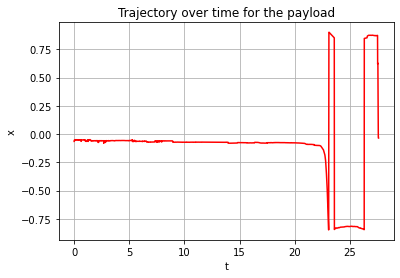

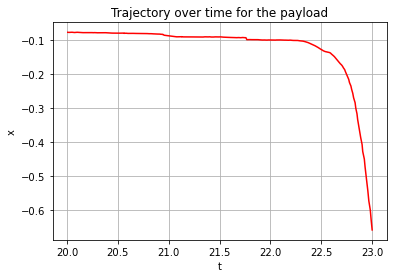

In [35]:
plot_trajectory(payload_poses['time_sec'].to_numpy(),
                payload_poses['orientation_x'].to_numpy(), 't', 'x', 'the payload')

zoomed_in_df = zoom(payload_poses, 20.0, 23.0)

plot_trajectory(
    zoomed_in_df['time_sec'].to_numpy(),
    zoomed_in_df['orientation_x'].to_numpy(),
    't',
    'x',
    'the payload'
)

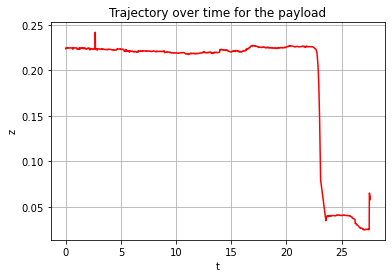

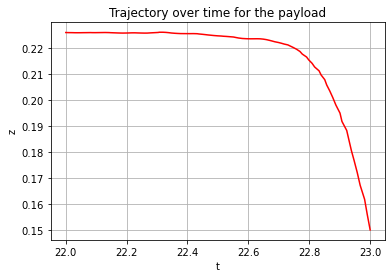

In [36]:
plot_trajectory(payload_poses['time_sec'].to_numpy(), payload_poses['position_z'].to_numpy(), 't', 'z', 'the payload')

zoomed_in_df = zoom(payload_poses, 22.0, 23.0)

plot_trajectory(
    zoomed_in_df['time_sec'].to_numpy(),
    zoomed_in_df['position_z'].to_numpy(),
    't',
    'z',
    'the payload'
)

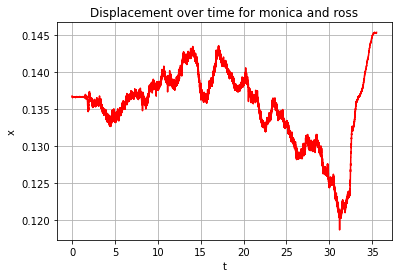

In [37]:
plot_displacements_over_time(
    time_series['time_sec'].to_numpy(),
    time_series['position_x_monica'].to_numpy(),
    time_series['position_x_ross'].to_numpy()
)

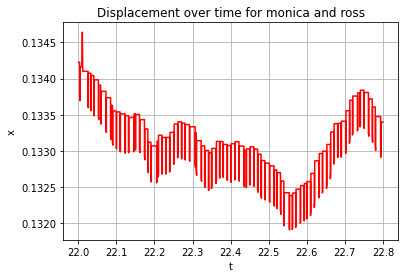

In [38]:
zoomed_in_df = zoom(time_series, 22.0, 22.8)

plot_displacements_over_time(
    zoomed_in_df['time_sec'].to_numpy(),
    zoomed_in_df['position_x_monica'].to_numpy(),
    zoomed_in_df['position_x_ross'].to_numpy()
)

In [39]:
force_time_series = get_time_series_data(bag_path, 'force')

force_time_series.info()

Bag duration: 35.51 seconds
Message count: 80001
Bag duration: 35.51 seconds
Message count: 80001
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2367 entries, 0 to 2366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp_monica  2367 non-null   float64
 1   time_sec          2367 non-null   float64
 2   data_monica       2367 non-null   float64
 3   timestamp_ross    2366 non-null   float64
 4   data_ross         2366 non-null   float64
dtypes: float64(5)
memory usage: 92.6 KB


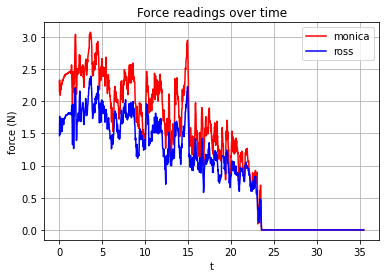

1.2209132611751556
0.9224579655396061


In [40]:
plot_forces(force_time_series['time_sec'].to_numpy(), force_time_series['data_monica'].to_numpy(), force_time_series['data_ross'].to_numpy())

print(force_time_series['data_monica'].mean())
print(force_time_series['data_ross'].mean())

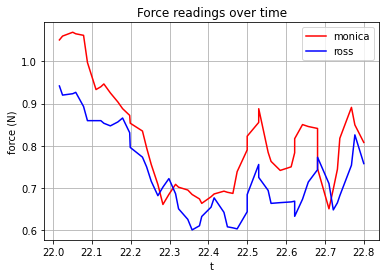

In [41]:
zoomed_in_df = zoom(force_time_series, 22.0, 22.8)

plot_forces(zoomed_in_df['time_sec'].to_numpy(),
            zoomed_in_df['data_monica'].to_numpy(), 
            zoomed_in_df['data_ross'].to_numpy())

In [42]:
# Determining distance traveled
monica_dist = time_series[
    (time_series['time_sec'] >= 33.4) &
    (time_series['time_sec'] <= 33.41)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

# Determining distance traveled
ross_dist = time_series[
    (time_series['time_sec'] >= 33.4) &
    (time_series['time_sec'] <= 33.41)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

print(f'(Twist started)\nMonica distance traveled: {monica_dist} \nRoss distance traveled: {ross_dist}')

(Twist started)
Monica distance traveled: 3.0486853182315827 
Ross distance traveled: 3.0486853182315827


In [43]:
# Determining distance traveled
monica_dist = time_series[
    (time_series['time_sec'] >= 33.7) &
    (time_series['time_sec'] <= 33.71)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

# Determining distance traveled
ross_dist = time_series[
    (time_series['time_sec'] >= 33.7) &
    (time_series['time_sec'] <= 33.71)
]['position_x_monica'].mean() - time_series['position_x_monica'].min()

print(
    f'(Dropped box)\nMonica distance traveled: {monica_dist} \nRoss distance traveled: {ross_dist}')

(Dropped box)
Monica distance traveled: 3.0540800392627716 
Ross distance traveled: 3.0540800392627716


## Analyzing CSV data

In [44]:
csv_path = '../../data/dynamic_admittance_trial_0/trajectory_data.csv'

traj_df = pd.read_csv(csv_path)

traj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   des_ross_x         1501 non-null   float64
 1   des_ross_y         1501 non-null   float64
 2   des_ross_theta     1501 non-null   float64
 3   des_mon_x          1501 non-null   float64
 4   des_mon_y          1501 non-null   float64
 5   des_mon_theta      1501 non-null   float64
 6   act_ross_x         1501 non-null   float64
 7   act_ross_y         1501 non-null   float64
 8   act_ross_theta     1501 non-null   float64
 9   act_mon_x          1501 non-null   float64
 10  act_mon_y          1501 non-null   float64
 11  act_mon_theta      1501 non-null   float64
 12  act_payload_x      1501 non-null   float64
 13  act_payload_y      1501 non-null   float64
 14  act_payload_theta  1501 non-null   float64
 15  dt                 1501 non-null   float64
 16  ros_time_ns        1501 

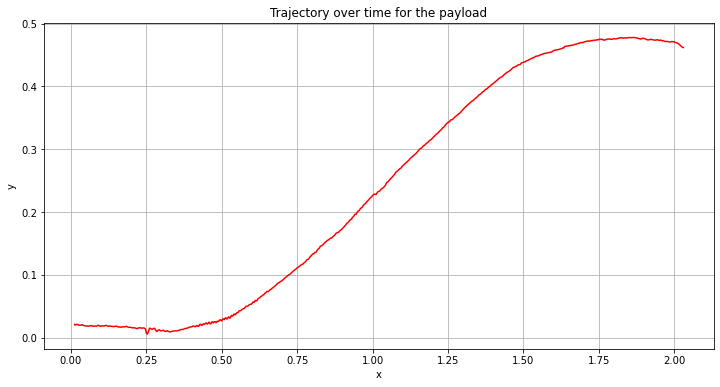

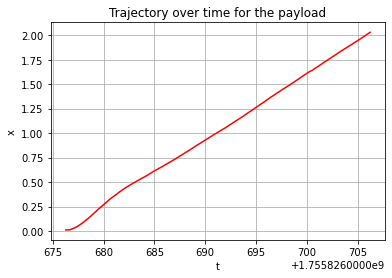

In [48]:
fig = plt.figure(figsize=(12, 6))

plot_trajectory(
    traj_df['act_payload_x'].to_numpy(),
    traj_df['act_payload_y'].to_numpy(),
    'x',
    'y',
    'the payload'
)

plot_trajectory(
    traj_df['ros_time_sec'].to_numpy(),
    traj_df['act_payload_x'].to_numpy(),
    't',
    'x',
    'the payload'
)

## Detecting Servo Motor Failure

In [46]:
admittance_df = pd.read_csv('../../data/test_trial/ross_admittance_data.csv')

admittance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32541 entries, 0 to 32540
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   t_p_x         32541 non-null  float64
 1   t_p_y         32541 non-null  float64
 2   t_p_z         32541 non-null  float64
 3   t_w           32541 non-null  float64
 4   t_x           32541 non-null  float64
 5   t_y           32541 non-null  float64
 6   t_z           32541 non-null  float64
 7   v_p_x         32541 non-null  float64
 8   v_p_y         32541 non-null  float64
 9   v_p_z         32541 non-null  float64
 10  v_w           32541 non-null  float64
 11  v_x           32541 non-null  float64
 12  v_y           32541 non-null  float64
 13  v_z           32541 non-null  float64
 14  force         32541 non-null  float64
 15  stiffness     32541 non-null  float64
 16  ros_time_sec  32541 non-null  float64
 17  ros_time_ns   32541 non-null  int64  
dtypes: float64(17), int64(1)
m

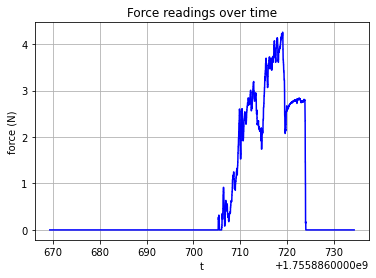

In [47]:
plot_force_data(admittance_df['ros_time_sec'].to_numpy(), admittance_df['force'].to_numpy())